# Building Unimodal Text Modal

In [67]:
cd ..

e:\


In [68]:
#ensuring that any edits to libraries you make are reloaded here automatically
#to ensuere charts or images displayed are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

In [69]:
#importing required modules
from exp.Required_Modules_And_Packages import *
from exp.Data_Reading_And_Preprocessing import *
from exp.Required_Integration_Functionalities_For_Transformer_To_Fastai import *
from exp.Required_Functionalities_To_Handal_Multimodal_Dataset import *
from exp.Multimodal_Model_With_Intermediate_Or_EmbraceNet_Fusion import *

In [70]:
path = Path('/notebooks/MultimodalTweetsClassification')
# path.ls()

In [71]:
path_img = path/'data_image'

In [72]:
# Uncomment the code if dataset and labels are in .tar.gz and .zip format respectively

# data = "CrisisMMD_v2.tar.gz"
# agreed_label = "crisismmd_datasplit_agreed_label.zip"
# untar_data_and_unzip_label(data,agreed_label)

In [73]:
#reading csv files and doing initial necessary processing
data_human_text,test_data_human_text = get_dataframe(*get_tsv_data_files('humanitarian_task_tsv_files'),path)

reading data and preprocessing it.....
done!!


In [74]:
print(f"shape of data: {data_human_text.shape}\n")
print(f"train set: {data_human_text['is_valid'].value_counts()[0]}")
print(f"valid set: {data_human_text['is_valid'].value_counts()[1]}")      
print("="*50)
print(f"shape of test data: {test_data_human_text.shape}\n")

shape of data: (15845, 10)

train set: 13608
valid set: 2237
shape of test data: (2237, 9)



In [75]:
data_human_text.head()

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image,is_valid
0,california_wildfires,917791291823591425,917791291823591425_1,pls share were capturing wildfire response rec...,data_image/california_wildfires/10_10_2017/917...,not_humanitarian,other_relevant_information,not_humanitarian,Negative,False
1,california_wildfires,917791291823591425,917791291823591425_0,pls share were capturing wildfire response rec...,data_image/california_wildfires/10_10_2017/917...,other_relevant_information,other_relevant_information,infrastructure_and_utility_damage,Negative,False
2,california_wildfires,917793137925459968,917793137925459968_0,california wildfires destroy more than structu...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive,False
3,california_wildfires,917793137925459968,917793137925459968_1,california wildfires destroy more than structu...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive,False
4,california_wildfires,917793137925459968,917793137925459968_2,california wildfires destroy more than structu...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive,False


# Self

In [76]:
from transformers import BertTokenizer, BertForSequenceClassification
from exp.Required_Integration_Functionalities_For_Transformer_To_Fastai import (
    TransformersBaseTokenizer, TransformersVocab, CustomTransformerModel
)
from exp.Required_Modules_And_Packages import *
from exp.Data_Reading_And_Preprocessing import *

In [77]:
num_labels = len(data_human_text['label_text'].unique())
model_path = r"e:\notebooks\MultimodalTweetsClassification\bert_local"
hf_tokenizer = BertTokenizer.from_pretrained(model_path)
hf_model = BertForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)

In [78]:
fastai_tokenizer = TransformersBaseTokenizer(hf_tokenizer)
fastai_vocab = TransformersVocab(hf_tokenizer)

In [80]:
from fastai.text import Tokenizer, TokenizeProcessor, NumericalizeProcessor

fastai_tokenizer = Tokenizer(
    tok_func=TransformersBaseTokenizer(hf_tokenizer, model_type='bert'),
    pre_rules=[], post_rules=[], n_cpus=1
)
fastai_vocab = TransformersVocab(hf_tokenizer)

processor = [TokenizeProcessor(tokenizer=fastai_tokenizer), NumericalizeProcessor(vocab=fastai_vocab)]



def get_text_data(dataframe, path, pad_first=True, pad_idx=1, batch_size=64, processor=None, vocab=None, num_workers=0):
    text_data = (TextList.from_df(dataframe, path, cols='tweet_text', processor=processor, vocab=vocab)
                 .split_from_df(col='is_valid')
                 .label_from_df(cols='label_text')
                 .databunch(bs=batch_size, pad_first=pad_first, pad_idx=pad_idx, num_workers=num_workers))
    return text_data

# function to create databunch object of test text data using test split

def get_test_text_data(dataframe, path, pad_first=True, pad_idx=1, batch_size=64, processor=None, vocab=None, num_workers=0):
    test_text_data = (TextList.from_df(dataframe, path, cols='tweet_text', processor=processor, vocab=vocab)
                      .split_none()
                      .label_from_df(cols='label_text')
                      .databunch(bs=batch_size, pad_first=pad_first, pad_idx=pad_idx, num_workers=num_workers))
    return test_text_data


data_clas = get_text_data(
    data_human_text,
    path,
    processor=processor,
    vocab=fastai_vocab
)
test_data_clas = get_test_text_data(
    test_data_human_text,
    path,
    processor=processor,
    vocab=fastai_vocab
)
data_clas.add_test(test_data_clas.train_ds)
data_clas.test_ds.y = test_data_clas.train_ds.y

In [81]:
pad_idx = hf_tokenizer.pad_token_id
model = CustomTransformerModel(pad_idx, hf_model)

In [83]:
from torch.nn import CrossEntropyLoss

learn_clas = Learner(
    data_clas,
    model,
    loss_func=CrossEntropyLoss(),
    metrics=[accuracy, Precision1(average='macro'), Precision1(average='weighted')],
    callback_fns=[ShowGraph]
)

epoch,train_loss,valid_loss,accuracy,precision1,precision1,time
0,0.798240,0.818849,0.704515,0.498546,0.701346,27:37
1,0.656802,0.782017,0.710773,0.503679,0.712521,26:10
2,0.514015,0.795498,0.716138,0.504295,0.715411,27:44


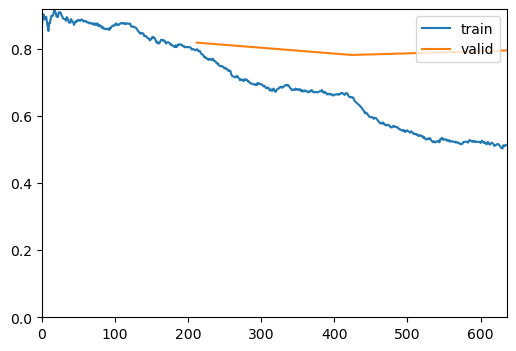

In [88]:
learn_clas.fit_one_cycle(3, 2e-5)

e:\notebooks\MultimodalTweetsClassification\venv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                        precision    recall  f1-score   support

                  affected_individuals       0.40      0.43      0.42        67
     infrastructure_and_utility_damage       0.61      0.63      0.62       164
                      not_humanitarian       0.79      0.81      0.80        70
            other_relevant_information       0.00      0.00      0.00         6
rescue_volunteering_or_donation_effort       0.78      0.64      0.70       625
              missing_or_found_persons       0.70      0.75      0.72       844
            vehicle_or_property_damage       0.75      0.85      0.79       453
       injured_or_deceased_individuals       0.00      0.00      0.00         8

                              accuracy                           0.72      2237
                             macro avg       0.50      0.51      0.51      2237
                          weighted avg       0.72      0.72      0.71      2237



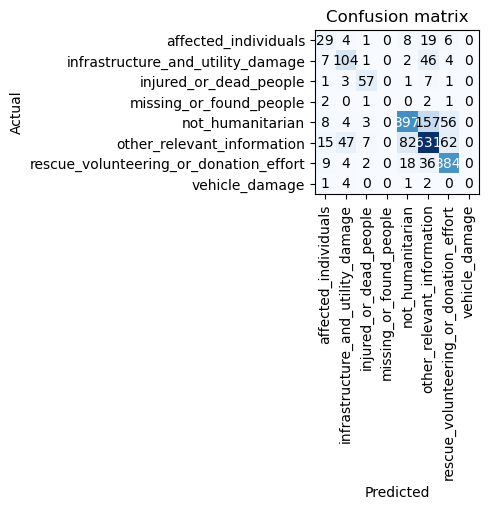

In [89]:
interp = ClassificationInterpretation.from_learner(learn_clas)
interp.plot_confusion_matrix(figsize=(5,5), dpi=100)

preds, y, losses = learn_clas.get_preds(ds_type=DatasetType.Valid, with_loss=True)
y_preds = preds.argmax(1)

target_names = [
    'affected_individuals',
    'infrastructure_and_utility_damage',
    'not_humanitarian',
    'other_relevant_information',
    'rescue_volunteering_or_donation_effort',
    'missing_or_found_persons',
    'vehicle_or_property_damage',
    'injured_or_deceased_individuals'
]
print(classification_report(y, y_preds, target_names=target_names))